<a href="https://colab.research.google.com/github/wtrekell/soylent-army/blob/main/colab/ai_vs_human_v2_2_v.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#CELL O1 - Installs
%pip install kaleido

In [2]:
# Cell 0.2a — Plotly → PNG support (force kaleido engine, self-test)

import subprocess
import sys
from pathlib import Path

_HAS_PLOTLY_PNG = False

try:
    import plotly.graph_objects as go
    import plotly.io as pio
    try:
        import kaleido  # ensure module is importable
        # Force the engine and do a self-test write
        test_fig = go.Figure(go.Scatter(x=[0,1], y=[0,1]))
        _ = test_fig.to_image(format="png", engine="kaleido")  # in-memory test
        _HAS_PLOTLY_PNG = True
        print("Kaleido detected:", getattr(kaleido, "__version__", "unknown"))
    except Exception as e:
        print("Kaleido not active. Attempting install…", e)
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "kaleido"])
            import kaleido  # retry
            test_fig = go.Figure(go.Scatter(x=[0,1], y=[0,1]))
            _ = test_fig.to_image(format="png", engine="kaleido")
            _HAS_PLOTLY_PNG = True
            print("Kaleido installed:", getattr(kaleido, "__version__", "unknown"))
        except Exception as e2:
            print("[WARN] Plotly PNG export unavailable:", e2)
except Exception as e:
    print("[WARN] Plotly not available:", e)

def save_plotly_png_and_html(fig, png_path: Path | None, html_path: Path | None):
    """Save Plotly figure to PNG (kaleido) and HTML."""
    if html_path is not None:
        try:
            fig.write_html(str(html_path), include_plotlyjs="cdn", full_html=True)
            print("HTML saved:", html_path)
        except Exception as e:
            print("[WARN] write_html failed:", e)
    if png_path is not None:
        if _HAS_PLOTLY_PNG:
            try:
                fig.write_image(str(png_path), engine="kaleido")  # << force engine
                print("PNG saved:", png_path)
            except Exception as e:
                print("[WARN] write_image failed (kaleido):", e)
        else:
            print("[INFO] PNG skipped: kaleido engine not available. Try: pip install kaleido")

print("Plotly PNG export available:", _HAS_PLOTLY_PNG)


/usr/local/lib/python3.12/dist-packages/kaleido/__init__.py:14: UserWarning: 


This means that static image generation (e.g. `fig.write_image()`) will not work.

Please upgrade Plotly to version 6.1.1 or greater, or downgrade Kaleido to version 0.2.1.

  from .kaleido import Kaleido


Kaleido not active. Attempting install… 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido

[WARN] Plotly PNG export unavailable: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido

Plotly PNG export available: False


In [3]:
# Cell 0.2b - Quick self-check
if _HAS_PLOTLY_PNG:
    import plotly.graph_objects as go
    tfig = go.Figure(go.Bar(x=["ok"], y=[1]))
    test_path = OUTPUT_FIG_DIR / f"_plotly_png_sanity_{_ts()}.png"
    tfig.write_image(str(test_path), engine="kaleido")
    print("Plotly PNG sanity check saved:", test_path)
else:
    print("Plotly PNG sanity check skipped (kaleido not available).")


Plotly PNG sanity check skipped (kaleido not available).


In [4]:
# Cell 0.3b — Imports & Global Theme
from __future__ import annotations

import datetime as dt
import json
import os
from pathlib import Path
from typing import Any

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# seaborn is used for a couple of charts (heatmap, bars)
try:
    import seaborn as sns
    _HAS_SNS = True
except Exception:
    _HAS_SNS = False

# Plotly for interactive charts (pie/donut, radar)
try:
    import plotly.express as px
    import plotly.graph_objects as go
    import plotly.io as pio
    pio.templates.default = "plotly_white"
    _HAS_PLOTLY = True
except Exception:
    _HAS_PLOTLY = False

# ---- Matplotlib defaults (export-safe) ----
mpl.rcParams["figure.dpi"] = 140
mpl.rcParams["savefig.dpi"] = 300
mpl.rcParams["font.size"] = 11
mpl.rcParams["axes.spines.top"] = False
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.titleweight"] = "semibold"
mpl.rcParams["figure.autolayout"] = True

if _HAS_SNS:
    sns.set_context("talk")
    sns.set_style("whitegrid")

print(f"Imports ok — seaborn={_HAS_SNS}, plotly={_HAS_PLOTLY}")


Imports ok — seaborn=True, plotly=True


In [5]:
# Cell 0.3 — Paths & Runtime Config
# --- USER INPUT: Specify the path to your input JSON file here ---
INPUT_JSON = Path("/content/content_complete_summary.json") # <--- CHANGE THIS PATH
# ------------------------------------------------------------------

OUTPUT_FIG_DIR = Path("figures")
OUTPUT_REP_DIR = Path("reports")

# Exports
EXPORT_PNG = True
EXPORT_SVG = False
EXPORT_HTML = True

# Ensure directories exist
OUTPUT_FIG_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_REP_DIR.mkdir(parents=True, exist_ok=True)

def _ts() -> str:
    return dt.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

print("Input JSON:", INPUT_JSON.resolve())
print("Figures  ->", OUTPUT_FIG_DIR.resolve())
print("Reports  ->", OUTPUT_REP_DIR.resolve())

Input JSON: /content/content_complete_summary.json
Figures  -> /content/figures
Reports  -> /content/reports


In [6]:
# Cell 0.2a — Plotly → PNG support (kaleido helper)
# Place this cell AFTER your Paths & Runtime Config (Cell 0.3) so OUTPUT_* dirs exist.

import subprocess
import sys
from pathlib import Path

_HAS_PLOTLY_PNG = False

try:
    import plotly.graph_objects as go
    import plotly.io as pio

    # Try a dry-run export; if it fails, attempt to install kaleido.
    try:
        _ = pio.to_image(go.Figure(go.Scatter(x=[0], y=[0])), format="png")
        _HAS_PLOTLY_PNG = True
    except Exception:
        try:
            print("Attempting to install 'kaleido' for Plotly image export…")
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "kaleido"])
            _ = pio.to_image(go.Figure(go.Scatter(x=[0], y=[0])), format="png")
            _HAS_PLOTLY_PNG = True
        except Exception as e:
            print("[WARN] Plotly PNG export unavailable (kaleido install failed).", e)

except Exception as e:
    print("[WARN] Plotly not available; PNG export skipped.", e)

def save_plotly_png_and_html(fig, png_path: Path | None, html_path: Path | None):
    """Save Plotly figure to PNG (if kaleido is available) and HTML (always)."""
    if png_path is not None:
        if _HAS_PLOTLY_PNG:
            try:
                fig.write_image(str(png_path))
                print("PNG saved:", png_path)
            except Exception as e:
                print("[WARN] write_image failed:", e)
        else:
            print("[INFO] To enable PNG export, install: pip install kaleido")

    if html_path is not None:
        try:
            fig.write_html(str(html_path), include_plotlyjs="cdn", full_html=True)
            print("HTML saved:", html_path)
        except Exception as e:
            print("[WARN] write_html failed:", e)

print("Plotly PNG export available:", _HAS_PLOTLY_PNG)


Attempting to install 'kaleido' for Plotly image export…
[WARN] Plotly PNG export unavailable (kaleido install failed). 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido

Plotly PNG export available: False


In [7]:
# Cell 1.1 — Load JSON (Interactive Input)
import sys
from pathlib import Path


# Define the load_json function here
def load_json(path: Path) -> dict[str, Any]:
    if not path.exists():
        raise FileNotFoundError(f"JSON not found: {path}")
    with path.open("r", encoding="utf-8") as f:
        return json.load(f)

# Temporarily capture stdout/stderr to avoid mixing input prompt
# with other print statements from previous runs if cell output is not cleared.
# This isn't strictly necessary for input() to work, but makes the prompt cleaner.
# old_stdout = sys.stdout
# sys.stdout = open(os.devnull, 'w')

try:
    # --- USER INPUT: Paste path to your JSON file here ---
    in_path = input("📁 Paste path to your JSON file: ").strip()
    # ----------------------------------------------------

    # sys.stdout = old_stdout # Restore stdout

    base = Path(in_path).expanduser().resolve()

    if not base.exists():
        raise FileNotFoundError(f"JSON file not found: {base}")

    global INPUT_JSON # Update the global variable defined in Cell 0.3
    INPUT_JSON = base

    global raw
    raw = load_json(INPUT_JSON)

    print(f"\nJSON loaded successfully from: {INPUT_JSON}")
    print("Top-level keys:", list(raw.keys()))

except FileNotFoundError as e:
    # sys.stdout = old_stdout # Restore stdout in case of error
    print(f"\nError: {e}", file=sys.stderr)
except Exception as e:
    # sys.stdout = old_stdout # Restore stdout in case of error
    print(f"\nAn error occurred: {e}", file=sys.stderr)

# Note: The variable 'raw' will be updated globally after successful loading.
# Subsequent cells that use 'raw' should be run after the "JSON loaded successfully" message appears.

📁 Paste path to your JSON file: /content/content_complete_summary.json

JSON loaded successfully from: /content/content_complete_summary.json
Top-level keys: ['version', 'doc_id', 'generated_at', 'doc_metrics', 'summary', 'rows', 'config', 'attribution_analysis']


In [8]:
# Cell 1.2 — Schema Check & Accessors
REQUIRED_KEYS = ["summary", "doc_metrics", "rows"]

missing = [k for k in REQUIRED_KEYS if k not in raw]
if missing:
    print("[WARN] Missing keys in JSON:", missing)
else:
    print("Schema checks passed.")

def getd(d: dict[str, Any], key: str, default=None):
    v = d.get(key, default)
    return default if v is None else v

summary = getd(raw, "summary", {})
doc_metrics = getd(raw, "doc_metrics", {})
rows = getd(raw, "rows", [])

print(f"rows: {len(rows)} sentence-level entries")


Schema checks passed.
rows: 90 sentence-level entries


In [9]:
# Cell 1.3 — Normalize to DataFrames (+ helpers) — FIXED FOR YOUR SCHEMA
def coerce_frame(obj):
    if isinstance(obj, pd.DataFrame):
        return obj.copy()
    if isinstance(obj, list):
        return pd.DataFrame(obj)
    if isinstance(obj, dict):
        if all(not isinstance(v, (list, dict)) for v in obj.values()):
            return pd.DataFrame([obj])
        return pd.DataFrame([obj])
    return pd.DataFrame()

def safe_percentages_from_counts(df: pd.DataFrame, count_col: str = "count") -> pd.DataFrame:
    if df.empty or count_col not in df:
        return df.assign(percent=0.0)
    vals = pd.to_numeric(df[count_col], errors="coerce").fillna(0)
    total = vals.sum()
    if total <= 0:
        return df.assign(percent=0.0)
    return df.assign(percent=(vals / total) * 100)

# -------- unpack using your schema --------
origin_dist = summary.get("origin_distribution", {})            # may be fractions (sum≈1) or counts
mod_dist = summary.get("modification_distribution", {})         # may be fractions (sum≈1) or counts

# Build origin / mod frames
df_origin = pd.DataFrame([{"category": k, "count": v} for k, v in origin_dist.items()])
df_mod    = pd.DataFrame([{"category": k, "count": v} for k, v in mod_dist.items()])

# Coerce, then compute % (works whether they are counts or fractions)
for _df in (df_origin, df_mod):
    if not _df.empty:
        _df["count"] = pd.to_numeric(_df["count"], errors="coerce").fillna(0.0)

df_origin = safe_percentages_from_counts(df_origin)
df_mod    = safe_percentages_from_counts(df_mod)

# Document metrics: flatten stylometrics
doc_metrics_flat = dict(doc_metrics)
sty = doc_metrics_flat.pop("stylometrics", {}) or {}
for k, v in sty.items():
    doc_metrics_flat[f"sty.{k}"] = v
df_doc_metrics = coerce_frame(doc_metrics_flat)

# Rows (sentence-level)
df_rows = coerce_frame(rows)

# Shares — prefer doc-level p_ai; else infer from rows
df_shares = pd.DataFrame(columns=["author", "share"])
p_ai_doc = pd.to_numeric(pd.Series([doc_metrics.get("p_ai")]), errors="coerce").dropna()
if not p_ai_doc.empty:
    ai_share = float(np.clip(p_ai_doc.iloc[0], 0, 1))
    df_shares = pd.DataFrame([{"author": "ai", "share": ai_share},
                              {"author": "human", "share": 1 - ai_share}])

print("Frames built:")
print("- df_origin:", df_origin.shape)
print("- df_mod:", df_mod.shape)
print("- df_shares:", df_shares.shape, "(doc p_ai used)" if not df_shares.empty else "(to infer)")
print("- df_doc_metrics (flattened):", df_doc_metrics.shape)
print("- df_rows:", df_rows.shape)


Frames built:
- df_origin: (4, 3)
- df_mod: (3, 3)
- df_shares: (2, 2) (doc p_ai used)
- df_doc_metrics (flattened): (1, 31)
- df_rows: (90, 13)


In [10]:
# Cell 2.1 — KPI Table (Document-Level) — FIXED TO PULL FROM doc_metrics / stylometrics
def kpi_val_from_doc(key: str, default=None):
    return pd.to_numeric(pd.Series([doc_metrics.get(key)]), errors="coerce").iloc[0]

# Readability/stats live under stylometrics
sty = doc_metrics.get("stylometrics", {}) or {}

kpis = {
    "perplexity":          kpi_val_from_doc("perplexity"),
    "burstiness_std":      kpi_val_from_doc("burstiness_std"),
    "fano_factor":         kpi_val_from_doc("fano_factor"),
    "ai_share (doc p_ai)": pd.to_numeric(pd.Series([doc_metrics.get("p_ai")]), errors="coerce").iloc[0],
    # stylometrics
    "ttr":                  sty.get("ttr"),
    "avg_word_len":         sty.get("avg_word_len"),
    "avg_sent_len_tokens":  sty.get("avg_sent_len_tokens"),
    "var_sent_len_tokens":  sty.get("var_sent_len_tokens"),
    "flesch_reading_ease":  sty.get("flesch_reading_ease"),
    "flesch_kincaid_grade": sty.get("flesch_kincaid_grade"),
    "gunning_fog":          sty.get("gunning_fog"),
}
df_kpis = pd.DataFrame([kpis]).T.reset_index()
df_kpis.columns = ["metric", "value"]
display(df_kpis)


,metric,value
0,perplexity,38.276199
1,burstiness_std,12.708901
2,fano_factor,9.217790
3,ai_share (doc p_ai),0.287158
4,ttr,0.420419
5,avg_word_len,4.657578
6,avg_sent_len_tokens,17.522222
7,var_sent_len_tokens,161.516173
8,flesch_reading_ease,58.672587
9,flesch_kincaid_grade,8.493304


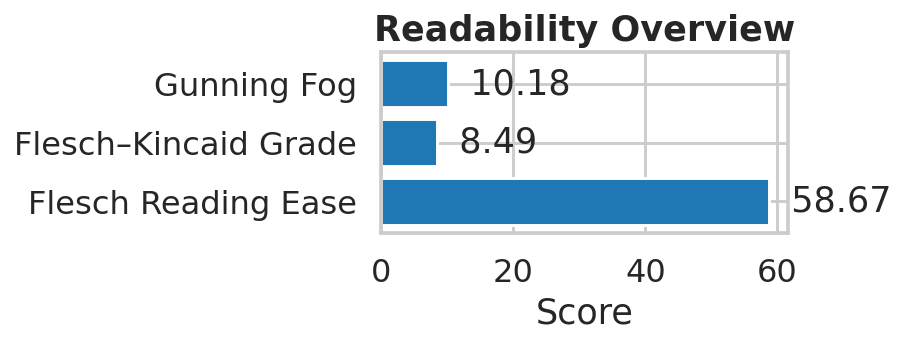

Saved: figures/readability_bars_2025-09-03_14-01-19.png


In [11]:
# Cell 2.2 — Readability Badge Bars (Matplotlib) — FIXED to include FK Grade

fig, ax = plt.subplots(figsize=(6.8, 2.8))

# Preferred canonical keys
canon_keys = [
    ("Flesch Reading Ease", "flesch_reading_ease"),
    ("Flesch–Kincaid Grade", "flesch_kincaid_grade"),  # << correct key
    ("Gunning Fog", "gunning_fog"),
]

# Light alias map (handled if your KPI table used other names)
aliases = {
    "fk_grade": "flesch_kincaid_grade",
    "fkgrade": "flesch_kincaid_grade",
}

# Helper to pull a value from df_kpis or doc_metrics.stylometrics
def get_readability_value(key: str):
    # 1) df_kpis (if present)
    if "df_kpis" in globals() and isinstance(df_kpis, pd.DataFrame) and not df_kpis.empty:
        target = key
        # accept alias rows in df_kpis
        if target not in df_kpis["metric"].values:
            for a, canon in aliases.items():
                if canon == key and a in df_kpis["metric"].values:
                    target = a
                    break
        if target in df_kpis["metric"].values:
            v = pd.to_numeric(df_kpis.set_index("metric").loc[target]["value"], errors="coerce")
            if pd.notna(v):
                return float(v)

    # 2) fallback: doc_metrics.stylometrics
    sty = (doc_metrics.get("stylometrics") or {})
    if key not in sty:
        # try alias in stylometrics too
        for a, canon in aliases.items():
            if canon == key and a in sty:
                key = a
                break
    v = sty.get(key, None)
    try:
        return None if v is None else float(v)
    except Exception:
        return None

# Collect values in the desired display order
labels, values = [], []
for display, k in canon_keys:
    v = get_readability_value(k)
    if v is not None:
        labels.append(display)
        values.append(v)

if values:
    y = np.arange(len(values))
    ax.barh(y, values)
    ax.set_yticks(y, labels)
    ax.set_title("Readability Overview", fontweight="semibold")
    ax.set_xlabel("Score")
    for idx, v in enumerate(values):
        ax.text(v, idx, f"  {v:.2f}", va="center")
else:
    ax.text(0.5, 0.5, "No readability metrics found.", ha="center", va="center", fontsize=12)

figpath = OUTPUT_FIG_DIR / f"readability_bars_{_ts()}.png"
if EXPORT_PNG:
    fig.savefig(figpath, bbox_inches="tight")
plt.show()
print("Saved:", figpath if EXPORT_PNG else "(not saved)")


In [12]:
# D3.1 — Origin distribution root-cause diagnostics

print("=== JSON Summary Keys ===")
print(list(summary.keys()))

print("\n=== Stages (from summary.stages) ===")
stages_list = (summary.get("stages") or ["draft","refined","edited","final"])
print(stages_list)

print("\n=== summary.origin_distribution (raw) ===")
print(summary.get("origin_distribution"))

print("\n=== df_origin (as built earlier) ===")
try:
    display(df_origin)
except Exception as e:
    print("df_origin not defined:", e)

# Try to see if we have any per-row stage labels we can count
rows_df = df_rows.copy() if 'df_rows' in globals() else pd.DataFrame()
stage_cols = [c for c in rows_df.columns if c.lower() in
              ["stage", "origin_stage", "author_stage", "stage_label", "source_stage"]]
print("\n=== Candidate stage columns in rows ===")
print(stage_cols)

if not rows_df.empty and stage_cols:
    for c in stage_cols:
        counts = rows_df[c].astype(str).str.lower().value_counts(dropna=False)
        print(f"\nValue counts in rows['{c}']:")
        print(counts)

# Inspect stage_metrics presence/shape
print("\n=== summary.stage_metrics present? ===")
has_stage_metrics = isinstance(summary.get("stage_metrics"), dict)
print(has_stage_metrics)
if has_stage_metrics:
    print("stage_metrics keys:", list(summary["stage_metrics"].keys())[:10])
    # optional: show any explicit counts if they exist
    for st, met in summary["stage_metrics"].items():
        if isinstance(met, dict):
            # sniff for any count info
            for k in ["sentences_total", "tokens_total", "count", "counts"]:
                if k in met:
                    print(f"  {st} has {k} =", met[k])


=== JSON Summary Keys ===
['origin_distribution', 'modification_distribution', 'counts', 'stages', 'stage_metrics', 'stage_similarity']

=== Stages (from summary.stages) ===
['draft', 'refined', 'edited', 'final']

=== summary.origin_distribution (raw) ===
{'draft': 0.26666666666666666, 'refined': 0.06666666666666667, 'edited': 0.6666666666666666, 'other': 0.0}

=== df_origin (as built earlier) ===
df_origin not defined: 'str' object is not callable

=== Candidate stage columns in rows ===
[]

=== summary.stage_metrics present? ===
True
stage_metrics keys: ['draft', 'refined', 'edited', 'final']


In [13]:
# Cell 3.1 — Origin Distribution (Donut) — FIXED for stage alignment & PNG export

if _HAS_PLOTLY and not df_origin.empty:
    df_plot = df_origin.copy()

    # === Patch: Align categories to canonical stages ===
    stages_list = summary.get("stages") or ["draft", "refined", "edited", "final"]

    # If only percent exists, reconstruct count proxy
    if "percent" in df_plot.columns and "count" not in df_plot.columns:
        df_plot["count"] = df_plot["percent"] / 100.0

    # Map "other" -> "final" if needed
    if "final" in stages_list and "final" not in df_plot["category"].values:
        if "other" in df_plot["category"].values:
            df_plot.loc[df_plot["category"].str.lower().eq("other"), "category"] = "final"

    # Collapse duplicates and align to stage order
    df_plot = (
        df_plot.groupby("category", as_index=False)["count"].sum()
        if "count" in df_plot.columns else
        df_plot.groupby("category", as_index=False)["percent"].sum()
    )
    complete = pd.DataFrame({"category": stages_list})
    df_plot = complete.merge(df_plot, on="category", how="left")

    # Fill missing numeric columns
    for c in ["count", "percent"]:
        if c in df_plot.columns:
            df_plot[c] = pd.to_numeric(df_plot[c], errors="coerce").fillna(0.0)

    # Recompute percent from count if available
    if "count" in df_plot.columns:
        total = df_plot["count"].sum()
        df_plot["percent"] = (df_plot["count"] / total) * 100.0 if total > 0 else 0.0
    else:
        s = df_plot["percent"].sum()
        df_plot["percent"] = (df_plot["percent"] / s * 100.0) if s > 0 else 0.0

    # === Plot ===
    fig = px.pie(
        df_plot,
        values="percent",
        names="category",
        hole=0.45,
        title="Origin Distribution (by percent)",
    )

    png_path  = OUTPUT_FIG_DIR / f"origin_donut_{_ts()}.png" if EXPORT_PNG else None
    html_path = OUTPUT_REP_DIR / f"origin_donut_{_ts()}.html" if EXPORT_HTML else None
    save_plotly_png_and_html(fig, png_path, html_path)

    fig.show()
else:
    print("Origin distribution not available or plotly missing.")


[INFO] To enable PNG export, install: pip install kaleido
HTML saved: reports/origin_donut_2025-09-03_14-01-20.html


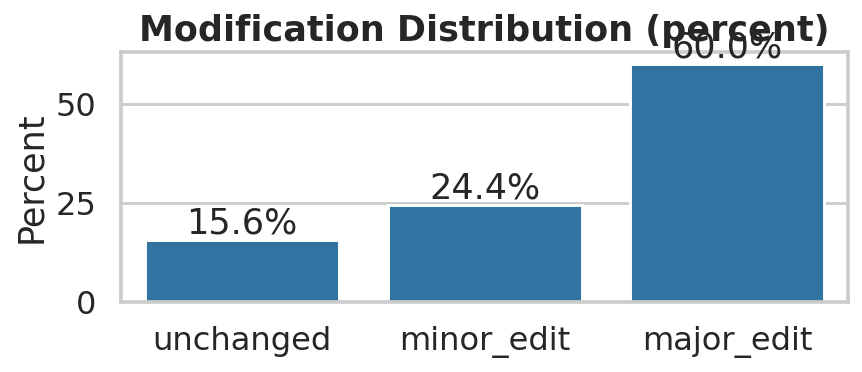

Saved: figures/mod_distribution_2025-09-03_14-01-21.png


In [14]:
# Cell 3.2 — Modification Distribution (Ordered Bar) — SAFE FOR FRACTIONS
if not df_mod.empty and {"category", "percent"}.issubset(df_mod.columns):
    order = ["unchanged", "minor_edit", "major_edit", "other"]
    categories = [c for c in order if c in df_mod["category"].tolist()] + \
                 [c for c in df_mod["category"].tolist() if c not in order]
    df_plot = df_mod.copy()
    df_plot["category"] = pd.Categorical(df_plot["category"], categories=categories, ordered=True)
    df_plot = df_plot.sort_values("category")

    fig, ax = plt.subplots(figsize=(6.5, 3.0))
    if _HAS_SNS:
        sns.barplot(data=df_plot, x="category", y="percent", ax=ax)
    else:
        ax.bar(df_plot["category"].astype(str), df_plot["percent"])
    ax.set_title("Modification Distribution (percent)")
    ax.set_xlabel("")
    ax.set_ylabel("Percent")
    for i, row in df_plot.reset_index(drop=True).iterrows():
        ax.text(i, row["percent"], f"{row['percent']:.1f}%", ha="center", va="bottom")
    figpath = OUTPUT_FIG_DIR / f"mod_distribution_{_ts()}.png"
    if EXPORT_PNG:
        fig.savefig(figpath, bbox_inches="tight")
    plt.show()
    print("Saved:", figpath if EXPORT_PNG else "(not saved)")
else:
    print("Modification distribution not available.")


/tmp/ipython-input-4211801072.py:40: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



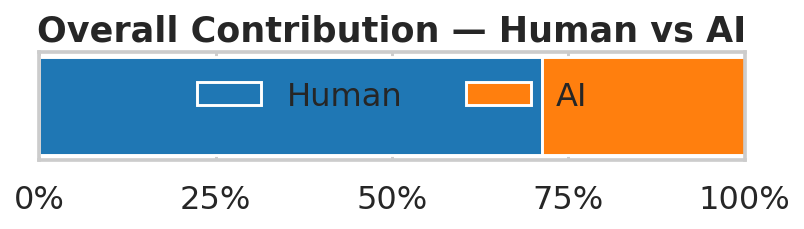

Saved: figures/stacked_share_2025-09-03_14-01-22.png


In [15]:
# Cell 3.3 — Stacked Bar: AI vs Human Share — FIXED FOR p_ai_ensemble / p_ai_transformer
def infer_shares_from_rows(df_rows: pd.DataFrame) -> pd.DataFrame | None:
    if df_rows.empty:
        return None
    # prefer ensemble, then transformer, then generic
    for key in ["p_ai_ensemble", "p_ai_transformer", "p_ai", "ai_probability", "ai_prob", "prob_ai"]:
        if key in df_rows.columns:
            s = pd.to_numeric(df_rows[key], errors="coerce")
            if s.notna().any():
                s = s.clip(0, None)
                if s.max() > 1.0:
                    s = (s - s.min()) / (s.max() - s.min() + 1e-9)
                return pd.DataFrame([{"author": "ai", "share": float(s.mean())},
                                     {"author": "human", "share": 1 - float(s.mean())}])
    for key in ["label", "pred_label", "author_label"]:
        if key in df_rows.columns:
            s = (pd.to_numeric(df_rows[key], errors="coerce") == 1).astype(float)
            return pd.DataFrame([{"author": "ai", "share": float(s.mean())},
                                 {"author": "human", "share": 1 - float(s.mean())}])
    return None

df_shares_use = df_shares.copy()
if df_shares_use.empty:
    inferred = infer_shares_from_rows(df_rows)
    if inferred is not None:
        df_shares_use = inferred

if not df_shares_use.empty and {"author", "share"}.issubset(df_shares_use.columns):
    shares = df_shares_use.set_index("author")["share"].reindex(["human", "ai"]).fillna(0)
    fig, ax = plt.subplots(figsize=(6.5, 1.0))
    ax.barh(["Contribution"], [shares["human"]], label="Human")
    ax.barh(["Contribution"], [shares["ai"]], left=[shares["human"]], label="AI")
    ax.set_xlim(0, 1)
    ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0], labels=[f"{int(v*100)}%" for v in [0, .25, .5, .75, 1]])
    ax.set_yticks([])
    ax.set_title("Overall Contribution — Human vs AI")
    ax.legend(loc="upper center", ncols=2, frameon=False)
    figpath = OUTPUT_FIG_DIR / f"stacked_share_{_ts()}.png"
    if EXPORT_PNG:
        fig.savefig(figpath, bbox_inches="tight")
    plt.show()
    print("Saved:", figpath if EXPORT_PNG else "(not saved)")
else:
    print("No share data available.")


In [16]:
# Cell 3.4 — Aggregate Contribution Pie (Human vs AI) — PNG+HTML

def _infer_ai_share(df_rows: pd.DataFrame) -> float | None:
    for k in ["p_ai_ensemble","p_ai_transformer","p_ai","ai_probability","ai_prob","prob_ai"]:
        if k in df_rows.columns:
            s = pd.to_numeric(df_rows[k], errors="coerce")
            if s.notna().any():
                s = s.clip(0, None)
                if s.max() > 1.0:
                    s = (s - s.min()) / (s.max() - s.min() + 1e-9)
                return float(s.mean())
    for k in ["label","pred_label","author_label"]:
        if k in df_rows.columns:
            s = (pd.to_numeric(df_rows[k], errors="coerce") == 1).astype(float)
            return float(s.mean())
    return None

ai_share = None
if pd.notna(doc_metrics.get("p_ai", None)):
    try: ai_share = float(doc_metrics["p_ai"])
    except: ai_share = None
if ai_share is None: ai_share = _infer_ai_share(df_rows)

if _HAS_PLOTLY and ai_share is not None:
    human = max(0.0, 1.0 - ai_share); ai = max(0.0, ai_share)
    df_agg = pd.DataFrame({"Author":["Human","AI"], "Share":[human, ai]})
    fig = px.pie(df_agg, values="Share", names="Author", title="Aggregate Contribution — Human vs AI", hole=0.25)

    png_path  = OUTPUT_FIG_DIR / f"agg_contrib_pie_{_ts()}.png" if EXPORT_PNG else None
    html_path = OUTPUT_REP_DIR / f"agg_contrib_pie_{_ts()}.html" if EXPORT_HTML else None
    save_plotly_png_and_html(fig, png_path, html_path)
    fig.show()
else:
    print("Aggregate contribution pie skipped.")


[INFO] To enable PNG export, install: pip install kaleido
HTML saved: reports/agg_contrib_pie_2025-09-03_14-01-22.html


In [17]:
# Cell 4.1 — Stylometric Table — FIXED (pull from stylometrics)
sty = doc_metrics.get("stylometrics", {}) or {}
stylometric_keys = [
    "ttr", "avg_word_len", "avg_sent_len_tokens", "var_sent_len_tokens",
    "comma_rate", "semicolon_rate", "colon_rate",
    "flesch_reading_ease", "flesch_kincaid_grade", "gunning_fog"
]
stylometrics = {k: sty.get(k) for k in stylometric_keys if k in sty}
df_stylo = pd.DataFrame([stylometrics]).T.reset_index()
df_stylo.columns = ["feature", "value"]
display(df_stylo)


TypeError: 'str' object is not callable

In [ ]:
# Cell 4.2 — Radar (Spider) Chart — MULTI-STAGE, FIXED BOUNDS, PNG+HTML

# 1) Which features we show on the radar:
radar_features = ["ttr", "avg_word_len", "avg_sent_len_tokens", "comma_rate", "lexical_density"]

# 2) Get global fixed bounds (prefer JSON feature_bounds; else sensible defaults)
default_bounds = {
    "ttr": (0.0, 0.80),
    "avg_word_len": (3.0, 7.0),
    "avg_sent_len_tokens": (5.0, 40.0),
    "comma_rate": (0.0, 0.05),
    "lexical_density": (0.0, 0.70),
}
feature_bounds = (raw.get("feature_bounds") or {})  # optional in JSON
bounds = {k: tuple(feature_bounds.get(k, default_bounds[k])) for k in radar_features}

# 3) Pull multi-stage metrics OR fall back to single doc_metrics
stages = (summary.get("stages") or [])
stage_metrics = summary.get("stage_metrics") or {}

# Helper: derive lexical_density from POS if missing
def ensure_lexical_density(stylo: dict) -> dict:
    if "lexical_density" not in stylo or stylo.get("lexical_density") is None:
        pos_keys = ["NOUN", "VERB", "ADJ", "ADV"]
        if all(k in stylo for k in pos_keys):
            stylo = dict(stylo)  # copy
            stylo["lexical_density"] = sum(float(stylo.get(k, 0) or 0) for k in pos_keys)
    return stylo

def extract_feature_vector(stylo: dict) -> list[float | None]:
    stylo = ensure_lexical_density(stylo or {})
    vals = []
    for k in radar_features:
        v = stylo.get(k, None)
        vals.append(None if v is None else float(v))
    return vals

def normalize_to_bounds(values: list[float | None], bounds_map: dict) -> list[float]:
    out = []
    for val, name in zip(values, radar_features, strict=False):
        if val is None:
            out.append(0.0)
            continue
        lo, hi = bounds_map[name]
        if hi <= lo:
            out.append(0.0)
        else:
            out.append(max(0.0, min(1.0, (val - lo) / (hi - lo))))
    return out

profiles = []   # list of (label, r_values_norm, raw_values)
labels = []

if stages and stage_metrics:
    # MULTI-STAGE path
    for st in stages:
        met = stage_metrics.get(st) or {}
        sty = (met.get("stylometrics") or {})
        raw_vals = extract_feature_vector(sty)
        norm_vals = normalize_to_bounds(raw_vals, bounds)
        profiles.append((st, norm_vals, raw_vals))
        labels.append(st)
else:
    # SINGLE-DOC fallback (previous behavior)
    sty = (doc_metrics.get("stylometrics") or {})
    raw_vals = extract_feature_vector(sty)
    norm_vals = normalize_to_bounds(raw_vals, bounds)
    profiles.append(("document", norm_vals, raw_vals))
    labels.append("document")

# 4) Plot with Plotly and export PNG/HTML
if _HAS_PLOTLY:
    theta = [k.replace("_", " ").title() for k in radar_features]
    fig = go.Figure()
    for lbl, r_norm, raw_vals in profiles:
        # Close the loop
        r_closed = list(r_norm) + [r_norm[0]]
        th_closed = theta + [theta[0]]
        fig.add_trace(go.Scatterpolar(
            r=r_closed,
            theta=th_closed,
            fill='toself',
            name=lbl
        ))

    fig.update_layout(
        title="Stylometric Profile by Stage (Fixed Scaling)",
        polar=dict(radialaxis=dict(visible=True, range=[0, 1])),
        legend=dict(orientation="h", yanchor="bottom", y=-0.15, xanchor="center", x=0.5)
    )

    # Annotate bounds in the subtitle (optional)
    subtitle = " | ".join([f"{k.replace('_',' ').title()}: {bounds[k][0]}–{bounds[k][1]}" for k in radar_features])
    fig.update_layout(margin=dict(t=90))
    fig.add_annotation(
        text=subtitle,
        x=0.5, xref="paper", y=1.06, yref="paper",
        showarrow=False, align="center", font=dict(size=10)
    )

    png_path  = OUTPUT_FIG_DIR / f"radar_{_ts()}.png" if EXPORT_PNG else None
    html_path = OUTPUT_REP_DIR / f"radar_{_ts()}.html" if EXPORT_HTML else None
    try:
        save_plotly_png_and_html(fig, png_path, html_path)  # uses the helper from Cell 0.2a
    except NameError:
        # Fallback if helper cell didn't run
        if EXPORT_HTML:
            fig.write_html(str(html_path), include_plotlyjs="cdn", full_html=True)
            print("HTML saved:", html_path)
        if EXPORT_PNG:
            try:
                fig.write_image(str(png_path))
                print("PNG saved:", png_path)
            except Exception as e:
                print("[WARN] Plotly PNG export unavailable:", e)

    fig.show()
else:
    print("Plotly not available for radar chart.")


In [ ]:
# Cell 4.3 — POS Distribution (Horizontal Bar) — FIXED (from stylometrics POS shares)
pos_keys = ["DET","PROPN","PRON","AUX","PUNCT","SCONJ","ADP","ADJ","NOUN","NUM","VERB","PART","CCONJ","ADV"]
pos_ratios = {k: sty[k] for k in pos_keys if k in sty}
if pos_ratios:
    df_pos = pd.DataFrame([{"pos": k, "ratio": v} for k, v in pos_ratios.items()])
    df_pos["ratio"] = pd.to_numeric(df_pos["ratio"], errors="coerce").fillna(0.0)
    if df_pos["ratio"].max() > 1.0:
        df_pos["ratio"] = df_pos["ratio"] / 100.0
    df_pos = df_pos.sort_values("ratio", ascending=True)
    fig, ax = plt.subplots(figsize=(6.5, 3.5))
    if _HAS_SNS:
        sns.barplot(data=df_pos, x="ratio", y="pos", ax=ax, orient="h")
    else:
        ax.barh(df_pos["pos"], df_pos["ratio"])
    ax.set_title("POS Tag Ratios")
    ax.set_xlabel("Ratio")
    ax.set_ylabel("")
    for i, row in df_pos.reset_index(drop=True).iterrows():
        ax.text(row["ratio"], i, f"  {row['ratio']:.2f}", va="center")
    path = OUTPUT_FIG_DIR / f"pos_ratios_{_ts()}.png"
    if EXPORT_PNG: fig.savefig(path, bbox_inches="tight")
    plt.show()
    print("Saved:", path if EXPORT_PNG else "(not saved)")
else:
    print("No POS ratios available.")


In [ ]:
# Cell 5.1 — Stage Similarity Heatmap (ensure labels)
sim_mat = None
stages = None

if isinstance(summary.get("stage_similarity"), list):
    sim_mat = np.array(summary["stage_similarity"], dtype=float)
if isinstance(summary.get("stages"), list):
    stages = [str(s) for s in summary["stages"]]

if sim_mat is not None and sim_mat.ndim == 2 and _HAS_SNS:
    fig, ax = plt.subplots(figsize=(5 + 0.35 * sim_mat.shape[0], 4.8))
    sns.heatmap(
        sim_mat, annot=True, fmt=".2f", cmap="vlag", square=True,
        xticklabels=stages if stages else "auto",
        yticklabels=stages if stages else "auto",
        cbar_kws={"label": "Similarity (0–1)"}
    )
    ax.set_title("Stage-to-Stage Similarity")
    path = OUTPUT_FIG_DIR / f"similarity_heatmap_{_ts()}.png"
    if EXPORT_PNG:
        fig.savefig(path, bbox_inches="tight")
    plt.show()
    print("Saved:", path if EXPORT_PNG else "(not saved)")
else:
    print("No similarity matrix available (or seaborn missing).")


In [ ]:
# Cell 5.2 — Top-K Edits Table — FIXED (uses your similarity/distance fields and final_sentence)
def compute_change_score(row: pd.Series) -> float | None:
    # Prefer explicit edit/distance
    for key in ["levenshtein", "edit_distance", "delta_score", "change_score"]:
        if key in row.index and pd.notna(row[key]):
            return float(row[key])
    # Otherwise, invert similarity
    for key in ["combined_sim", "semantic_sim", "tfidf_sim", "jaccard", "similarity_to_previous", "similarity_prev"]:
        if key in row.index and pd.notna(row[key]):
            try: return 1.0 - float(row[key])
            except Exception: pass
    return None

df_edits = df_rows.copy()
text_col = None
for cand in ["final_sentence", "sentence", "text", "content", "span", "origin_sentence"]:
    if cand in df_edits.columns:
        text_col = cand; break
if text_col is None:
    print("No text column found for edits table.")
else:
    df_edits["change_score"] = df_edits.apply(compute_change_score, axis=1)
    df_edits = df_edits.dropna(subset=["change_score"])
    if not df_edits.empty:
        df_top = df_edits.sort_values("change_score", ascending=False).head(15)
        display(df_top[[text_col, "change_score"]].rename(columns={text_col:"sentence"}).reset_index(drop=True))
    else:
        print("No change scores available to rank edits.")


In [ ]:
# Cell 6.1 — Sentence-Level AI Probability Heatmap — FIXED (p_ai_ensemble / p_ai_transformer + final_sentence)

def get_ai_probs(df_rows: pd.DataFrame) -> np.ndarray | None:
    if df_rows.empty:
        return None
    for key in ["p_ai_ensemble", "p_ai_transformer", "p_ai", "ai_probability", "ai_prob", "prob_ai"]:
        if key in df_rows.columns:
            s = pd.to_numeric(df_rows[key], errors="coerce")
            if s.notna().any():
                s = s.clip(0, None)
                if s.max() > 1.0:
                    s = (s - s.min()) / (s.max() - s.min() + 1e-9)
                return s.values.reshape(-1, 1)
    for key in ["label", "pred_label", "author_label"]:
        if key in df_rows.columns:
            s = (pd.to_numeric(df_rows[key], errors="coerce") == 1).astype(float)
            return s.values.reshape(-1, 1)
    return None

def get_texts(df_rows: pd.DataFrame) -> list[str]:
    for c in ["final_sentence", "sentence", "text", "content", "span", "origin_sentence"]:
        if c in df_rows.columns:
            return df_rows[c].fillna("").astype(str).tolist()
    return [f"Sentence {i+1}" for i in range(len(df_rows))]

# ---- Plot heatmap ----
probs = get_ai_probs(df_rows)
if probs is not None and _HAS_SNS:
    N = probs.shape[0]
    fig, ax = plt.subplots(figsize=(4.0, max(3.5, N * 0.18)))
    sns.heatmap(probs, cmap="vlag", annot=False, cbar_kws={"label": "AI Probability"}, vmin=0, vmax=1)
    ax.set_title("Sentence-Level AI Probability Heatmap")
    ax.set_xlabel("Probability")
    ax.set_ylabel("Sentence #")
    step = max(1, N // 30)
    ax.set_yticks(np.arange(0, N, step) + 0.5, labels=[str(i+1) for i in range(0, N, step)])
    path = OUTPUT_FIG_DIR / f"ai_prob_heatmap_{_ts()}.png"
    if EXPORT_PNG: fig.savefig(path, bbox_inches="tight")
    plt.show()
    print("Saved:", path if EXPORT_PNG else "(not saved)")
elif probs is None:
    print("No per-sentence probabilities available in rows.")
else:
    print("Seaborn not available; cannot render heatmap.")


In [ ]:
# Cell 6.2 — Probability Stripe (1D Rug/Line) — FIXED
probs = get_ai_probs(df_rows)
if probs is not None:
    p = probs.flatten()
    x = np.arange(len(p))
    fig, ax = plt.subplots(figsize=(7.5, 1.8))
    ax.scatter(x, [0.5] * len(p), s=np.clip(p * 80, 8, 80), alpha=0.85)  # size ~ prob
    ax.set_ylim(0, 1)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_title("AI Probability Stripe (by Sentence Order)")
    path = OUTPUT_FIG_DIR / f"ai_prob_stripe_{_ts()}.png"
    if EXPORT_PNG: fig.savefig(path, bbox_inches="tight")
    plt.show()
    print("Saved:", path if EXPORT_PNG else "(not saved)")
else:
    print("No probabilities available for stripe plot.")


In [ ]:
# Cell 6.3 — Text Highlighting (HTML Export) — FIXED (uses final_sentence + probs)
def build_highlight_html(df_rows: pd.DataFrame, title: str = "Sentence-Level Highlighting") -> str:
    probs = get_ai_probs(df_rows)
    if probs is None:
        return "<p>No AI probabilities available to highlight.</p>"
    texts = get_texts(df_rows)

    def prob_to_hex(p: float) -> str:
        p = float(np.clip(p, 0, 1))
        if p <= 0.5:
            t = p / 0.5
            r = int((1 - t) * 66 + t * 255)
            g = int((1 - t) * 133 + t * 255)
            b = int((1 - t) * 244 + t * 255)
        else:
            t = (p - 0.5) / 0.5
            r = int((1 - t) * 255 + t * 219)
            g = int((1 - t) * 255 + t * 68)
            b = int((1 - t) * 255 + t * 55)
        return f"#{r:02x}{g:02x}{b:02x}"

    items = []
    for i, (txt, p) in enumerate(zip(texts, probs.flatten().tolist(), strict=False)):
        color = prob_to_hex(p)
        txt_color = "#000000" if p < 0.65 else "#111111"
        items.append(
            f'<div style="background:{color};padding:6px;border-radius:6px;margin:6px 0;color:{txt_color};">'
            f'<strong>{i+1:02d}</strong> — {txt} '
            f'<span style="float:right;opacity:.8;">AI p={p:.2f}</span>'
            f'</div>'
        )

    html = f"""<!DOCTYPE html>
<html>
<head>
<meta charset="utf-8"/>
<title>{title}</title>
<meta name="viewport" content="width=device-width, initial-scale=1"/>
<style>
body {{ font-family: -apple-system, Segoe UI, Roboto, Helvetica, Arial, sans-serif; margin: 18px; line-height: 1.45; }}
h1 {{ font-size: 20px; margin: 0 0 12px 0; }}
.sub {{ color: #555; margin-bottom: 16px; }}
.legend {{ margin: 16px 0; display:flex; gap:8px; align-items:center; }}
.legend .swatch {{ width: 18px; height: 18px; border-radius: 4px; display:inline-block; border:1px solid rgba(0,0,0,.08); }}
</style>
</head>
<body>
<h1>Document Analysis: Sentence-Level Highlighting</h1>
<div class="sub">Background color encodes AI probability (blue=lower, white=mid, red=higher).</div>
<div class="legend">
  <span class="swatch" style="background:#4285f4;"></span> 0.0
  <span class="swatch" style="background:#ffffff;"></span> 0.5
  <span class="swatch" style="background:#db4437;"></span> 1.0
</div>
{''.join(items)}
</body>
</html>
"""
    return html

html = build_highlight_html(df_rows)
outpath = OUTPUT_REP_DIR / f"highlighted_{_ts()}.html"
if EXPORT_HTML:
    with outpath.open("w", encoding="utf-8") as f:
        f.write(html)
print("Highlight HTML saved:", outpath if EXPORT_HTML else "(not saved)")


In [ ]:
# Cell 7.1 — Figure Export Helper (Matplotlib bulk save)
def save_all_open_matplotlib(prefix: str = "figure"):
    fig_nums = plt.get_fignums()
    saved_paths = []
    for i in fig_nums:
        fig = plt.figure(i)
        if EXPORT_PNG:
            path_png = OUTPUT_FIG_DIR / f"{prefix}_{i}_{_ts()}.png"
            fig.savefig(path_png, bbox_inches="tight")
            saved_paths.append(str(path_png))
        if EXPORT_SVG:
            path_svg = OUTPUT_FIG_DIR / f"{prefix}_{i}_{_ts()}.svg"
            fig.savefig(path_svg, bbox_inches="tight")
            saved_paths.append(str(path_svg))
    return saved_paths

print("Bulk save helper ready. Call save_all_open_matplotlib() if needed.")


In [ ]:
# Cell 7.2 — Lightweight HTML Report Stitching
def build_summary_report(
    df_kpis: pd.DataFrame,
    fig_dir: Path = OUTPUT_FIG_DIR,
    extra_sections: list[str] | None = None
) -> str:
    # Collect the most recent relevant figures (best-effort)
    pngs = sorted(fig_dir.glob("*.png"), key=os.path.getmtime)[-12:]
    imgs_html = "\n".join(
        f'<div style="margin:10px 0;"><img src="../{p}" style="max-width:100%;border:1px solid #eee;border-radius:8px"/></div>'
        for p in map(lambda x: x.as_posix(), pngs)
    )
    # KPIs table (basic HTML)
    if not df_kpis.empty:
        tbl = df_kpis.copy()
        tbl["metric"] = tbl["metric"].str.replace("_", " ").str.title()
        tbl_html = (
            "<table style='border-collapse:collapse;width:100%'>"
            "<thead><tr><th style='text-align:left;padding:6px;border-bottom:1px solid #ddd'>Metric</th>"
            "<th style='text-align:left;padding:6px;border-bottom:1px solid #ddd'>Value</th></tr></thead><tbody>"
            + "\n".join(
                f"<tr><td style='padding:6px;border-bottom:1px solid #f2f2f2'>{m}</td>"
                f"<td style='padding:6px;border-bottom:1px solid #f2f2f2'>{'' if pd.isna(v) else v}</td></tr>"
                for m, v in tbl[["metric","value"]].itertuples(index=False)
            )
            + "</tbody></table>"
        )
    else:
        tbl_html = "<p>No KPI metrics available.</p>"

    extra_html = "\n".join(extra_sections or [])

    return f"""<!DOCTYPE html>
<html>
<head>
<meta charset="utf-8"/>
<title>Visualization Report</title>
<meta name="viewport" content="width=device-width, initial-scale=1"/>
<style>
body {{ font-family: -apple-system, Segoe UI, Roboto, Helvetica, Arial, sans-serif; margin: 24px; line-height: 1.5; color: #111; }}
h1, h2 {{ font-weight: 600; }}
h1 {{ font-size: 22px; margin: 0 0 14px 0; }}
h2 {{ font-size: 18px; margin: 22px 0 8px 0; }}
.section {{ margin-bottom: 26px; }}
.kicker {{ color: #444; margin-bottom: 12px; }}
</style>
</head>
<body>
<h1>Visualization Report</h1>
<div class="kicker">Generated: {dt.datetime.now().isoformat(timespec='seconds')}</div>
<div class="section">
  <h2>Key Metrics</h2>
  {tbl_html}
</div>
<div class="section">
  <h2>Figures</h2>
  {imgs_html if imgs_html else "<p>No figure PNGs found.</p>"}
</div>
{extra_html}
</body>
</html>
"""

report_html = build_summary_report(df_kpis, OUTPUT_FIG_DIR)
report_path = OUTPUT_REP_DIR / f"visualization_report_{_ts()}.html"
if EXPORT_HTML:
    with report_path.open("w", encoding="utf-8") as f:
        f.write(report_html)
print("Report saved:", report_path if EXPORT_HTML else "(not saved)")


In [ ]:
# Cell 7.3 — Manifest (Artifacts Index)
def make_manifest(fig_dir: Path = OUTPUT_FIG_DIR, rep_dir: Path = OUTPUT_REP_DIR) -> dict[str, Any]:
    figs = sorted(fig_dir.glob("*.*"), key=os.path.getmtime)
    reps = sorted(rep_dir.glob("*.*"), key=os.path.getmtime)
    return {
        "generated_at": dt.datetime.now().isoformat(timespec="seconds"),
        "figures": [p.as_posix() for p in figs],
        "reports": [p.as_posix() for p in reps],
        "input_json": INPUT_JSON.as_posix(),
    }

manifest = make_manifest()
manifest_path = OUTPUT_REP_DIR / f"manifest_{_ts()}.json"
with manifest_path.open("w", encoding="utf-8") as f:
    json.dump(manifest, f, indent=2)
print("Manifest saved:", manifest_path)
display(pd.json_normalize(manifest, sep="."))


In [ ]:
# Cell 8.0 — Sanity Echo (what data we actually found)
print("Summary:")
print(" - df_origin:", df_origin.shape, "sample:", df_origin.head(3).to_dict('records'))
print(" - df_mod:", df_mod.shape, "sample:", df_mod.head(3).to_dict('records'))
print(" - df_shares:", df_shares.shape, df_shares.to_dict('records') if not df_shares.empty else "(empty)")
print(" - doc-level metrics keys:", list(doc_metrics.keys())[:10])
print(" - stylometrics keys:", list(doc_metrics.get('stylometrics', {}).keys())[:10])
print(" - df_rows:", df_rows.shape, "cols:", list(df_rows.columns))
print("Done.")


In [ ]:
import zipfile
from pathlib import Path


def create_output_zip(manifest: dict[str, Any], json_path: Path, fig_dir: Path, rep_dir: Path):
    """Creates a zip archive of generated figures and reports in the directory containing the input JSON."""

    if not json_path.is_file():
        print(f"Warning: Input JSON path is not a file or does not exist: {json_path}. Skipping creating zip archive.")
        return

    json_directory = json_path.parent
    zip_filename = f"visualization_outputs_{_ts()}.zip"
    zip_path = json_directory / zip_filename

    print(f"Creating zip archive: {zip_path}")

    try:
        with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
            # Collect all generated files from the manifest
            all_generated_files = manifest.get("figures", []) + manifest.get("reports", [])

            for file_path_str in all_generated_files:
                try:
                    source_path = Path(file_path_str)
                     # Ensure source path is absolute and exists
                    if not source_path.is_absolute():
                        # Assuming figures and reports were saved relative to the current working directory (likely /content)
                        source_path = Path(os.getcwd()) / source_path


                    if source_path.exists():
                        # Add file to zip, preserving directory structure relative to fig_dir/rep_dir
                        if source_path.is_relative_to(fig_dir):
                            arcname = source_path.relative_to(fig_dir)
                        elif source_path.is_relative_to(rep_dir):
                             arcname = source_path.relative_to(rep_dir)
                        else:
                             arcname = source_path.name # Fallback

                        zipf.write(source_path, arcname=arcname)
                        # print(f"Added to zip: {source_path} as {arcname}") # Uncomment for verbose output
                    else:
                        print(f"Warning: Generated file not found: {source_path}. Skipping.")
                except Exception as e:
                    print(f"Error adding file {file_path_str} to zip: {e}")

        print(f"Zip archive created successfully: {zip_path}")

    except Exception as e:
        print(f"Error creating zip archive: {e}")


# Call the function using the manifest and INPUT_JSON from previous cells
if 'manifest' in globals() and 'INPUT_JSON' in globals():
    create_output_zip(manifest, INPUT_JSON, OUTPUT_FIG_DIR, OUTPUT_REP_DIR)
else:
    print("Manifest or INPUT_JSON not found. Please run preceding cells.")

In [ ]:
# Diagnostics: why a given visualization didn't render/save

from pathlib import Path

import numpy as np
import pandas as pd


def yesno(x): return "✅" if x else "❌"

checks = []

# --- Environment flags & paths ---
checks.append(("seaborn available (_HAS_SNS)", _HAS_SNS))
checks.append(("plotly available (_HAS_PLOTLY)", _HAS_PLOTLY))

checks.append(("EXPORT_PNG is True", bool(EXPORT_PNG)))
checks.append(("EXPORT_HTML is True", bool(EXPORT_HTML)))

checks.append(("Figures dir exists", OUTPUT_FIG_DIR.exists()))
checks.append(("Reports dir exists", OUTPUT_REP_DIR.exists()))

# --- JSON / DataFrames present ---
checks.append(("raw loaded (raw)", 'raw' in globals()))
checks.append(("summary present", isinstance(summary, dict)))
checks.append(("doc_metrics present", isinstance(doc_metrics, dict)))
checks.append(("rows present", isinstance(rows, list)))

# --- Normalized frames ---
checks.append(("df_origin non-empty & has [category,percent]", (not df_origin.empty) and {"category","percent"}.issubset(df_origin.columns)))
checks.append(("df_mod non-empty & has [category,percent]", (not df_mod.empty) and {"category","percent"}.issubset(df_mod.columns)))
checks.append(("df_doc_metrics non-empty", not df_doc_metrics.empty))
checks.append(("df_rows non-empty", not df_rows.empty))

# --- Readability metrics (3 bars expected) ---
sty = doc_metrics.get("stylometrics", {}) or {}
checks.append(("Readability: flesch_reading_ease exists", "flesch_reading_ease" in sty))
checks.append(("Readability: flesch_kincaid_grade exists", "flesch_kincaid_grade" in sty))
checks.append(("Readability: gunning_fog exists", "gunning_fog" in sty))

# --- Stacked share gates ---
# starting df_shares_use logic again here to see if we can compute it
def _infer_shares_from_rows(df_rows: pd.DataFrame):
    for k in ["p_ai_ensemble","p_ai_transformer","p_ai","ai_probability","ai_prob","prob_ai"]:
        if k in df_rows.columns:
            s = pd.to_numeric(df_rows[k], errors="coerce")
            if s.notna().any():
                s = s.clip(0, None)
                if s.max() > 1.0:
                    s = (s - s.min())/(s.max() - s.min() + 1e-9)
                return float(s.mean())
    for k in ["label","pred_label","author_label"]:
        if k in df_rows.columns:
            s = (pd.to_numeric(df_rows[k], errors="coerce") == 1).astype(float)
            return float(s.mean())
    return None

p_ai_doc = pd.to_numeric(pd.Series([doc_metrics.get("p_ai")]), errors="coerce").dropna()
ai_share_from_doc = float(p_ai_doc.iloc[0]) if not p_ai_doc.empty else None
ai_share_from_rows = _infer_shares_from_rows(df_rows)

checks.append(("AI share (doc p_ai present)", ai_share_from_doc is not None))
checks.append(("AI share (rows inferable)", ai_share_from_rows is not None))

# --- POS ratios presence ---
pos_keys = ["DET","PROPN","PRON","AUX","PUNCT","SCONJ","ADP","ADJ","NOUN","NUM","VERB","PART","CCONJ","ADV"]
checks.append(("POS ratios present (any of the standard tags)", any(k in sty for k in pos_keys)))

# --- Stage metrics & similarity (for multi-profile radar & heatmap) ---
summ = summary or {}
has_stage_metrics = isinstance(summ.get("stage_metrics"), dict) and bool(summ.get("stage_metrics"))
has_stages = isinstance(summ.get("stages"), list) and bool(summ.get("stages"))
has_stage_similarity = isinstance(summ.get("stage_similarity"), list)
checks.append(("Stage metrics present", has_stage_metrics))
checks.append(("Stages list present", has_stages))
checks.append(("Stage similarity matrix present", has_stage_similarity))

# --- Probability columns for per-sentence plots ---
prob_cols_present = any(c in df_rows.columns for c in ["p_ai_ensemble","p_ai_transformer","p_ai","ai_probability","ai_prob","prob_ai","label","pred_label","author_label"])
checks.append(("Per-sentence probabilities/labels present", prob_cols_present))

# ---- Print summary table ----
print("=== Visualization Gates ===")
for name, ok in checks:
    print(f"{yesno(ok)} {name}")

# ---- Quick hints based on failures ----
print("\n=== Hints ===")
if not _HAS_PLOTLY:
    print("- Plotly is missing; donut/radar won't render. Install plotly.")
try:
    # See if PNG export via kaleido is available from the helper
    print(f"- Plotly PNG export available: {_HAS_PLOTLY_PNG}")
except NameError:
    print("- Plotly PNG helper cell (0.2a) not found; PNG export for Plotly may be skipped.")

if df_origin.empty or not {"category","percent"}.issubset(df_origin.columns):
    print("- Origin donut skipped: df_origin empty or missing ['category','percent']. Ensure origin_distribution present (fractions or counts).")

if df_mod.empty or not {"category","percent"}.issubset(df_mod.columns):
    print("- Modification bar skipped: df_mod empty or missing ['category','percent']. Ensure modification_distribution present.")

if not prob_cols_present:
    print("- Sentence-level heatmap/stripe skipped: no probability or label columns found in rows.")

if not (("flesch_reading_ease" in sty) and ("flesch_kincaid_grade" in sty) and ("gunning_fog" in sty)):
    print("- Readability bars may show fewer than 3 items: double-check stylometrics keys spelled exactly.")

if not has_stage_metrics:
    print("- Multi-stage radar skipped: add summary.stage_metrics with per-stage stylometrics.")
if not has_stage_similarity:
    print("- Stage similarity heatmap skipped: add summary.stage_similarity (square matrix) aligned to summary.stages.")

# ---- List saved artifacts ----
def list_latest(p: Path, glob="*.*", n=20):
    files = sorted(p.glob(glob), key=lambda x: x.stat().st_mtime if x.exists() else 0, reverse=True)
    return [f"{i+1:02d}. {f.name}" for i,f in enumerate(files[:n])]

print("\n=== Files in figures/ (newest first) ===")
for line in list_latest(OUTPUT_FIG_DIR, "*.png", n=30):
    print(line)

print("\n=== Files in reports/ (newest first) ===")
for line in list_latest(OUTPUT_REP_DIR, "*.*", n=30):
    print(line)
